In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
def plot_o_info_heatmap(df, dim1, dim2, ax, **kargs):

    # Pivot the data to get a matrix form suitable for heatmap plotting
    pivot_table = df.pivot(columns=dim1, index=dim2, values="O-information")

    # Create the heatmap
    sns.heatmap(
        pivot_table, cmap="vlag", center=0, ax=ax,
        annot=False, fmt=".2f", cbar=True,
        linewidths=.5,
        **kargs
    )

    # Draw a black border around the cells that satisfy the condition 1 - dim2 == dim1
    for i, row_index in enumerate(pivot_table.index):
        for j, col_index in enumerate(pivot_table.columns):
            if abs((1 - row_index) - col_index) < 0.001:
                # Add a rectangle with a black border around the cell
                rect = patches.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', alpha=0.4, lw=2)
                ax.add_patch(rect)


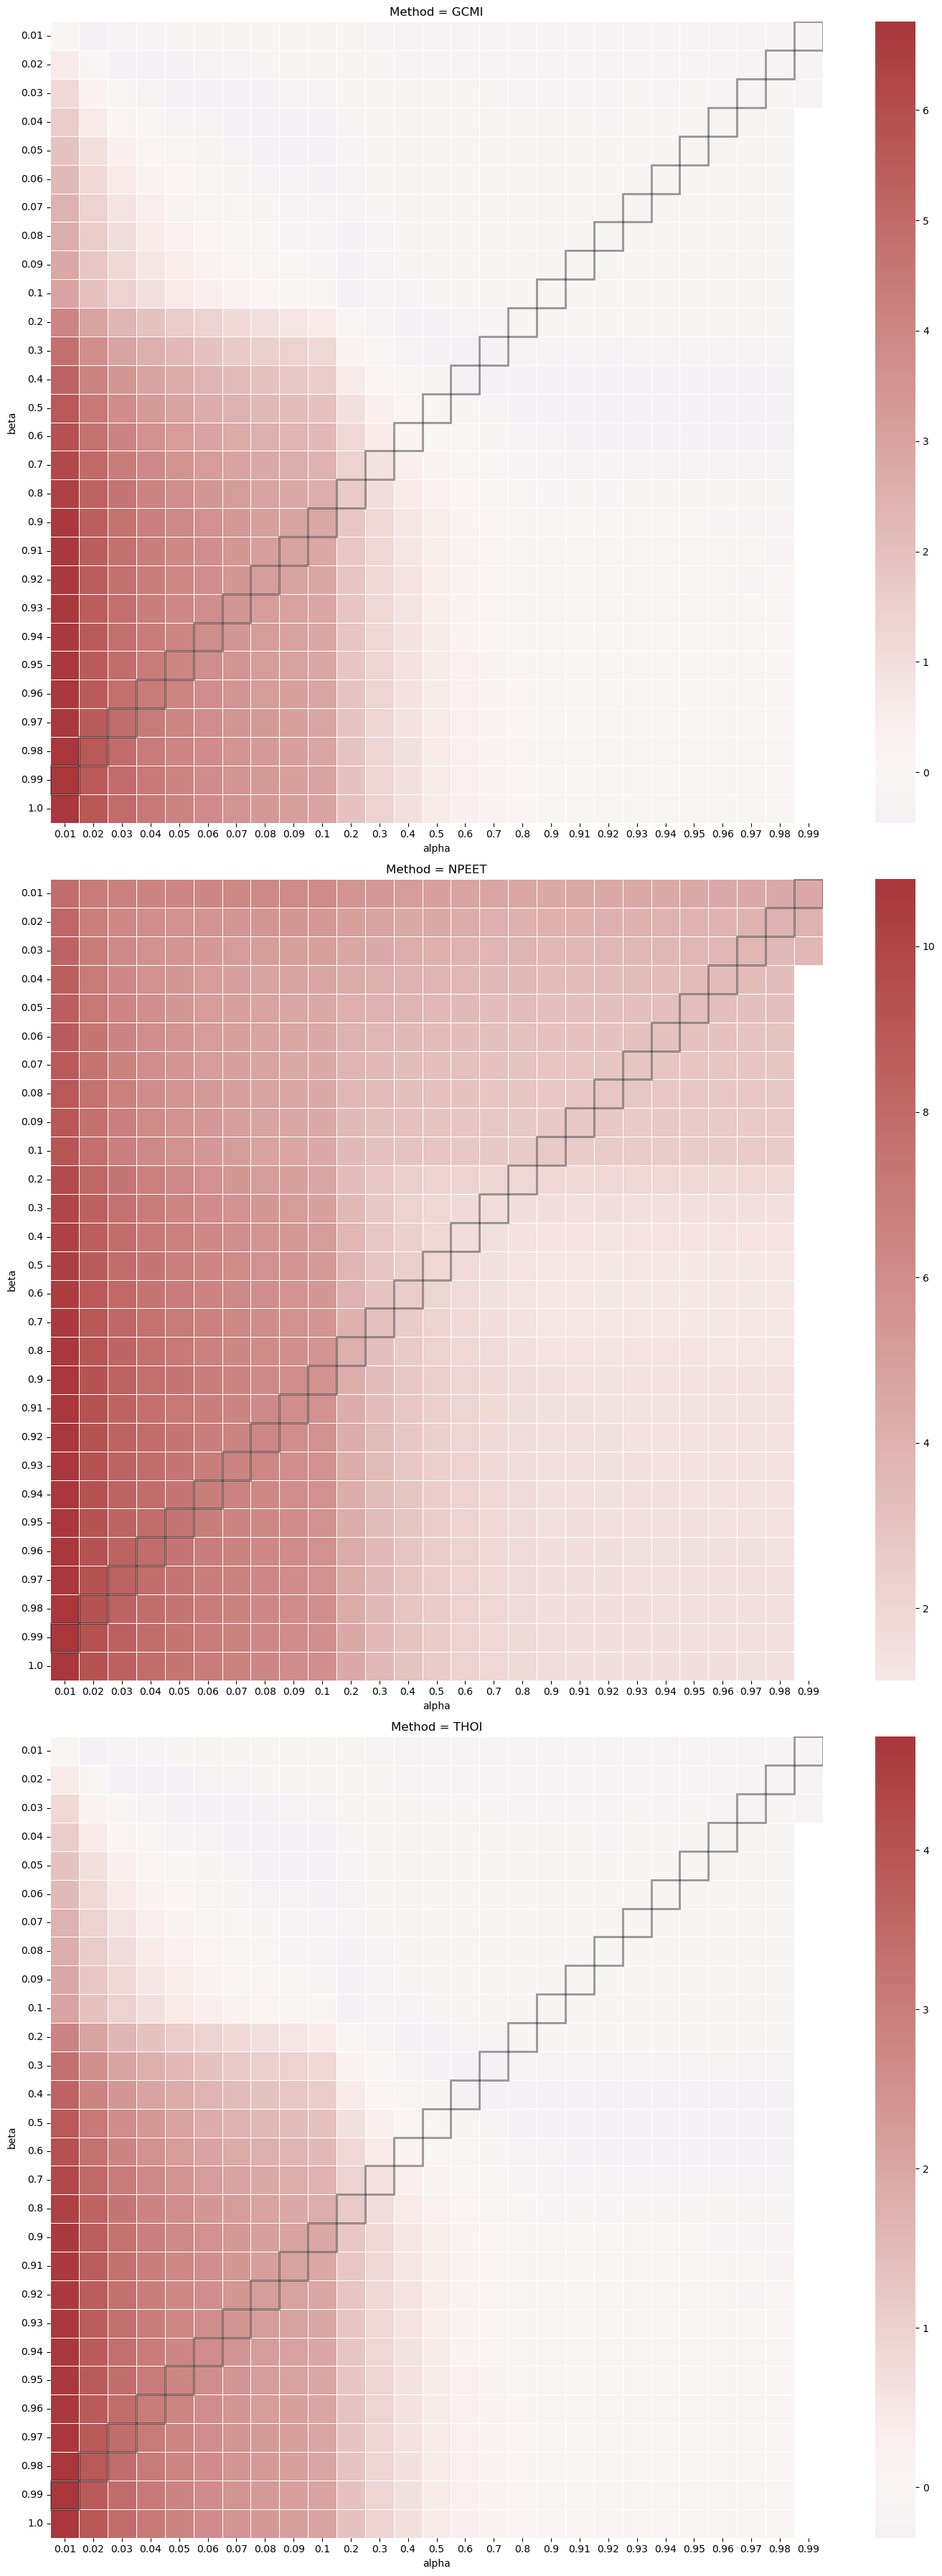

In [37]:
df = pd.read_csv('../benchmarking/results/o_info/system-relu_repeat-20_t-10000.tsv', sep='\t')

nplets_groups = df.groupby('n-plet')
methods = df['method'].unique()

fig, axes = plt.subplots(len(methods), 1, figsize=(15, len(methods)*12))

for ax, (method, group) in zip(axes,df.groupby('method')):

    plot_o_info_heatmap(group, 'alpha', 'beta', ax)
    ax.set_title(f'Method = {method}')
    ax.set_aspect('equal','box')

plt.tight_layout()
plt.show()

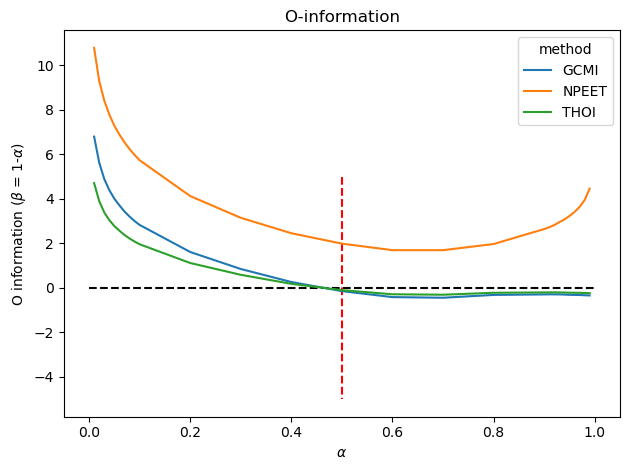

In [41]:
df = pd.read_csv('../benchmarking/results/o_info/system-relu_repeat-20_t-10000.tsv', sep='\t')

# keep for all values of alpha, only the value of beta == 1-alpha
df = df[abs((1 - df.alpha) - df.beta) < 0.001]

sns.lineplot(df, x='alpha', y='O-information', hue='method')
plt.hlines(0, 0.0, 1.0, color='black', linestyles='--')
plt.vlines(0.5, 5, -5, color='red', linestyles='--')
plt.title(f'O-information')

plt.ylabel(r'O information ($\beta$ = 1-$\alpha$)')
plt.xlabel(r'$\alpha$')

plt.tight_layout()
plt.show()

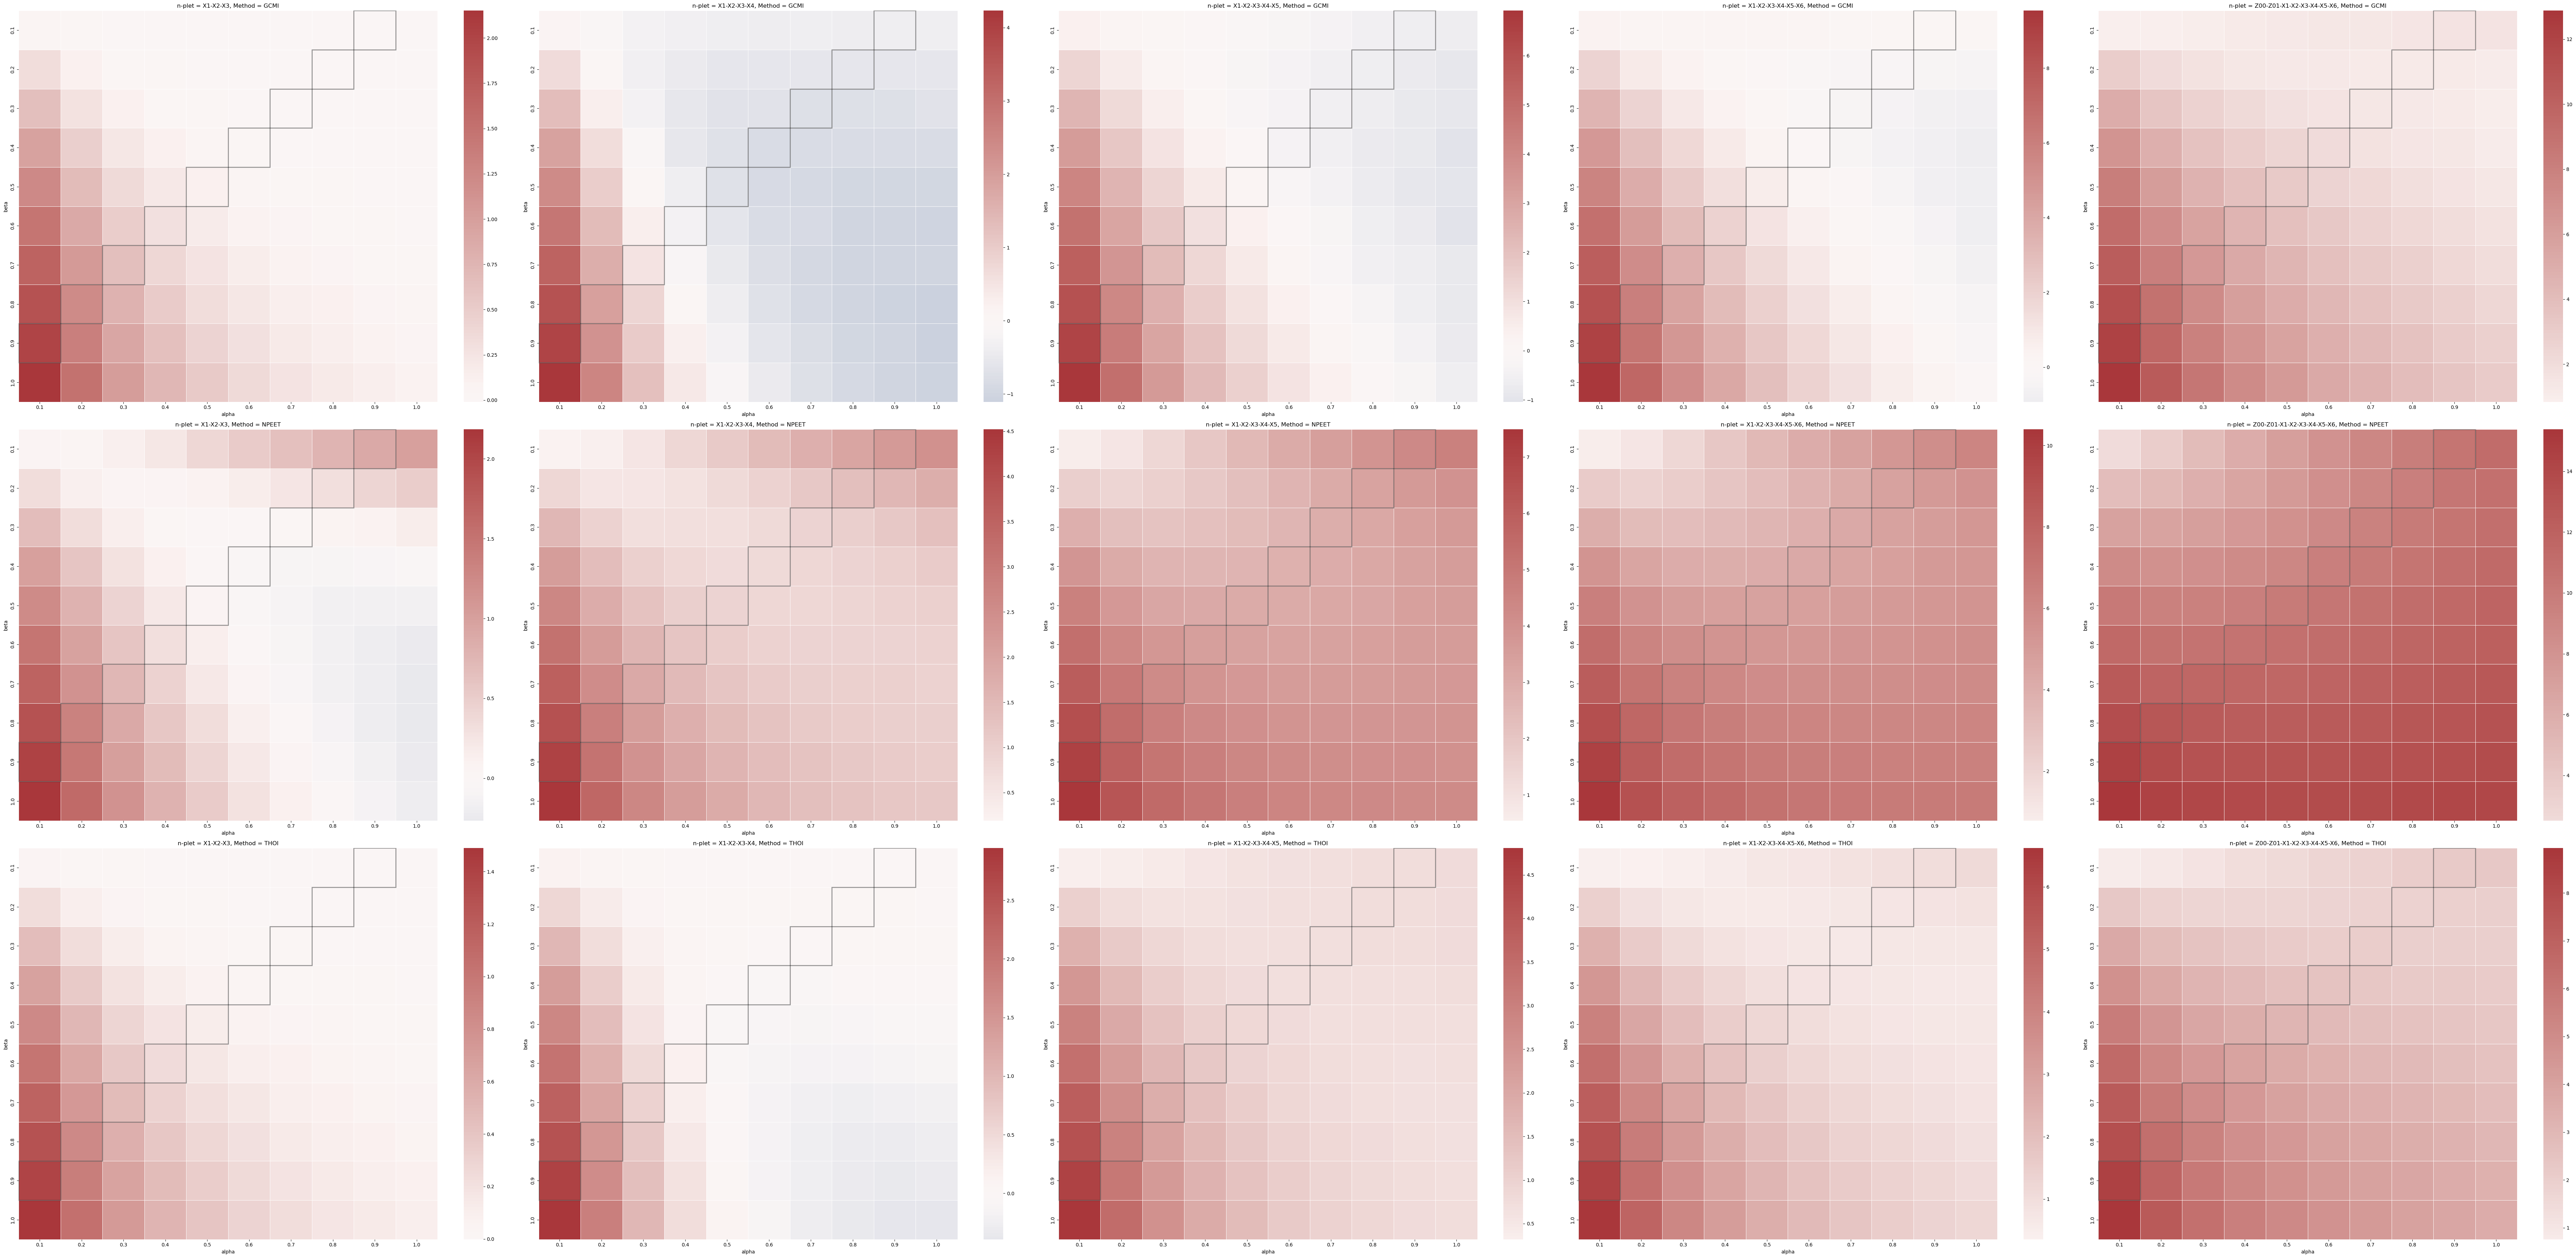

In [40]:
nplets = ['X1-X2-X3','X1-X2-X3-X4','X1-X2-X3-X4-X5','X1-X2-X3-X4-X5-X6','Z00-Z01-X1-X2-X3-X4-X5-X6']

df = pd.read_csv('../benchmarking/results/o_info/system-flat_repeat-20_t-10000.tsv', sep='\t')
df = df[df.gamma == 0.1]
df = df[df['n-plet'].isin(nplets)]

methods = df.groupby('method')

fig, axes = plt.subplots(len(methods), len(nplets), figsize=(len(nplets)*15, len(methods)*12))

for method_axes, (method, df_method) in zip(axes, methods):
      
        for ax, (nplet, df_nplet) in zip(method_axes, df_method.groupby('n-plet')):
    
            df_temp = df_nplet[df_nplet['method'] == method]
            plot_o_info_heatmap(df_nplet, 'alpha', 'beta', ax)
            ax.set_title(f'n-plet = {nplet}, Method = {method}')

plt.tight_layout()
plt.show()